In [ ]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *

# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Prepare data
# mean, weights, moments = prepare_data(par)

In [92]:
variables = ["extensive_v2", "yearly_hours"]
mean, variance_diag = load_and_process_data(
    "Data/mean_matrix.csv",
    "Data/variance_matrix.csv",
    par,
    variables
)


In [100]:
weights = np.diag(1 / variance_diag)

In [97]:
def randomize_theta_init(theta_init, bounds, pct=0.10):
    randomized = []
    for val, (lower, upper) in zip(theta_init, bounds):
        delta = pct * val
        min_val = max(lower, val - delta)
        max_val = min(upper, val + delta)
        randomized_val = np.random.uniform(min_val, max_val)
        randomized.append(randomized_val)
    return np.array(randomized)

# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta")
theta_init = np.array([0.970226, 1.082688, 1.833200, 11.655756, 11.496965])
# theta_init = np.array([0.968841, 1.090965, 2.147452, 12.092745, 9.981338, 0.010004, 0.016148])¨
# theta_init = np.array([0.968858, 1.094038, 2.133708, 10.819902, 9.341826, 0.012762, 0.014129])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 20.0),  # mu
               (0.0, 15.0),  # zeta
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

theta_random = randomize_theta_init(theta_init, orig_bounds)
theta_random_scaled = scale_params(theta_random, orig_bounds)

In [ ]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean, weights, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_random_scaled,
    method='nelder-mead',
    bounds=[(0,1)] * len(theta_random_scaled),
    tol=1e-6,
    options={"maxiter":2000}
)


0.891978, 1.010000, 1.665867, 11.332030, 11.515158, 
Error = 44.87, Time = 85.5885 seconds
0.936577, 1.010000, 1.665867, 11.332030, 11.515158, 
Error = 64.69, Time = 87.5156 seconds
0.891978, 1.055500, 1.665867, 11.332030, 11.515158, 
Error = 11.70, Time = 116.3540 seconds
0.891978, 1.010000, 1.744161, 11.332030, 11.515158, 
Error = 42.07, Time = 113.0239 seconds
0.891978, 1.010000, 1.665867, 11.898632, 11.515158, 
Error = 45.24, Time = 102.6308 seconds
0.891978, 1.010000, 1.665867, 11.332030, 12.090916, 
Error = 37.61, Time = 99.4464 seconds
0.847379, 1.028200, 1.697185, 11.558671, 11.745461, 
Error = 14.34, Time = 89.5238 seconds
0.874138, 1.035480, 1.709712, 10.856085, 11.837583, 
Error = 12.26, Time = 86.4565 seconds
0.867003, 1.045672, 1.727249, 11.232309, 11.966553, 
Error = 12.23, Time = 86.7549 seconds
0.857012, 1.059941, 1.642191, 11.192420, 12.147110, 
Error = 63.93, Time = 85.8004 seconds
0.883237, 1.022485, 1.718668, 11.297128, 11.673146, 
Error = 20.61, Time = 87.1938 seco

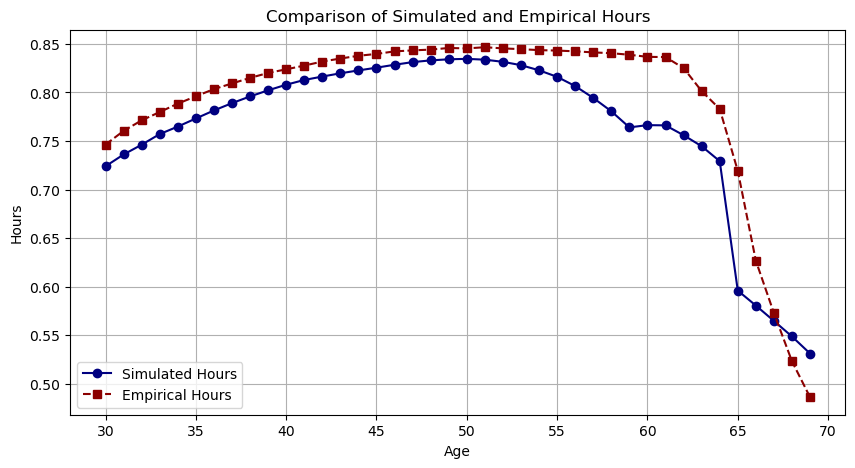

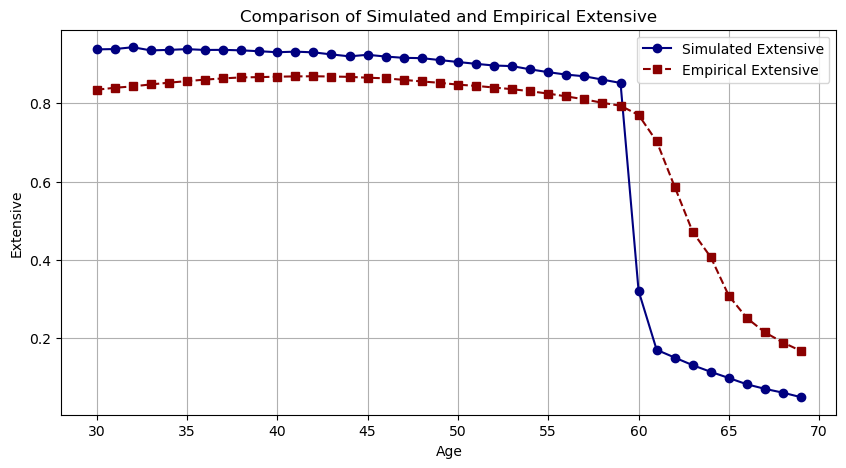

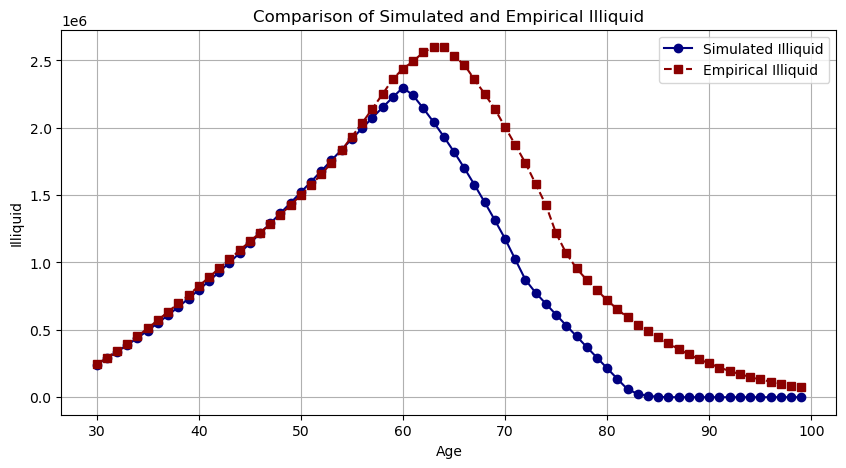

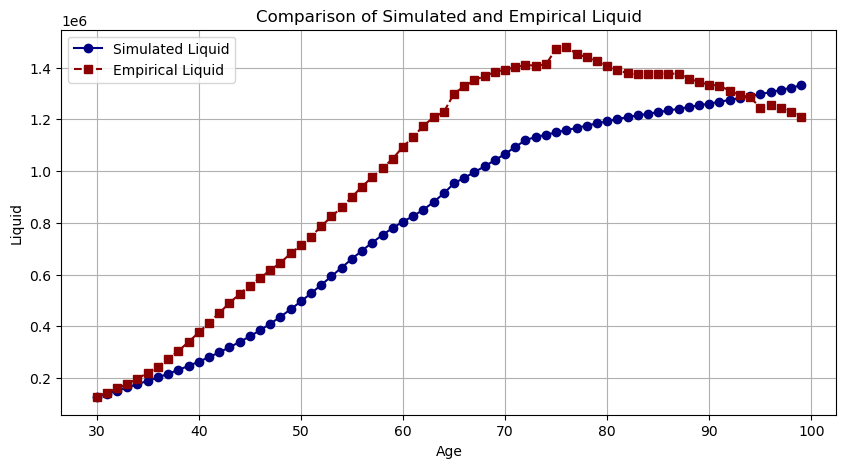

In [ ]:
# Load the model with calibrated values
theta_names = ("beta", "beta_1", "zeta")
# theta_final = np.array([0.991, 1.126, 7.350, 9.986, 10.0, 0.7, 1.1 ])
# theta_final = unscale_params(res.x, orig_bounds)
# theta_final = np.array([0.961, 1.127, 2.645, 6.657, 0.009, 0.041])
# theta_final = np.array([9.74192566e-01, 1.20491719e+00, 3.02178825e+00, 1.43315495e+01,
#        2.95781276e+00, 1.00033844e-02, 2.12865706e-02])
# theta_final = np.array([9.74192566e-01, 1.10491719e+00, 2.02178825e+00, 1.43315495e+01,
#        9.55781276e+00, 1.00033844e-02, 2.12865706e-02])

# theta_final = np.array([0.967, 1.092, 2.185, 13.509, 10.129, 0.010,  0.018 ])
# theta_final = np.array([0.965983, 1.086876, 1.988108, 12.118338, 10.027730])
# theta_final = np.array([0.971631, 1.081956, 1.810639, 11.380222, 11.488916])

# theta_final = np.array([0.971631, 0.058225])

theta_final = np.array([0.971631, 0.058225, 12.117360])


for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:40], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
model.par

namespace(opt_tol=1e-06,
          opt_maxiter=1000,
          start_age=30,
          T=70,
          beta=0.971631,
          sigma=1.09043,
          gamma=2.15709,
          mu=13.011158,
          a_bar=0.001,
          zeta=12.11736,
          r_a=0.010049,
          r_s=0.016058,
          upsilon=0.0,
          w_0=158.198926,
          k_0=6.0,
          beta_1=0.058225,
          beta_2=-0.000299,
          delta=0.064412,
          k_0_var=3.813044,
          full_time_hours=1924.0,
          k_scale=1.0,
          labor_market_rate=0.08,
          employment_deduction_rate=0.875,
          bottom_tax_rate=0.113,
          top_tax_rate=0.15,
          municipal_tax_rate=0.2491,
          personal_allowance=46000,
          employment_deduction_cap=33300,
          top_tax_threshold=498900,
          retirement_age=35,
          range=5,
          first_retirement=30,
          last_retirement=40,
          retirement_window=11,
          m=12.0,
          tau=array([0.126604

In [9]:
par.w_0*1924

304374.733624

In [10]:
np.nanmean(np.where(sim.ex[:,0]==1.0, sim.w[:,0], np.nan))

460572.5896657754

(array([1.004e+03, 1.770e+02, 2.020e+02, 1.990e+02, 2.200e+02, 2.420e+02,
        2.440e+02, 2.410e+02, 2.860e+02, 2.750e+02, 2.750e+02, 2.730e+02,
        2.740e+02, 2.860e+02, 3.050e+02, 2.830e+02, 2.920e+02, 2.740e+02,
        2.610e+02, 2.680e+02, 2.360e+02, 2.230e+02, 2.280e+02, 2.110e+02,
        1.950e+02, 1.920e+02, 1.880e+02, 1.720e+02, 1.910e+02, 1.950e+02,
        1.440e+02, 1.340e+02, 1.250e+02, 1.170e+02, 1.280e+02, 1.150e+02,
        1.000e+02, 9.300e+01, 8.600e+01, 8.700e+01, 8.200e+01, 7.400e+01,
        6.100e+01, 7.500e+01, 6.000e+01, 5.100e+01, 4.500e+01, 3.700e+01,
        4.500e+01, 3.600e+01, 3.700e+01, 2.400e+01, 3.300e+01, 3.100e+01,
        2.100e+01, 2.900e+01, 2.500e+01, 2.100e+01, 1.600e+01, 9.000e+00,
        1.000e+01, 1.300e+01, 1.100e+01, 9.000e+00, 1.000e+01, 9.000e+00,
        7.000e+00, 1.000e+01, 7.000e+00, 4.000e+00, 5.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 8.000e+00,
        0.000e+00, 2.000e+00, 1.000e+0

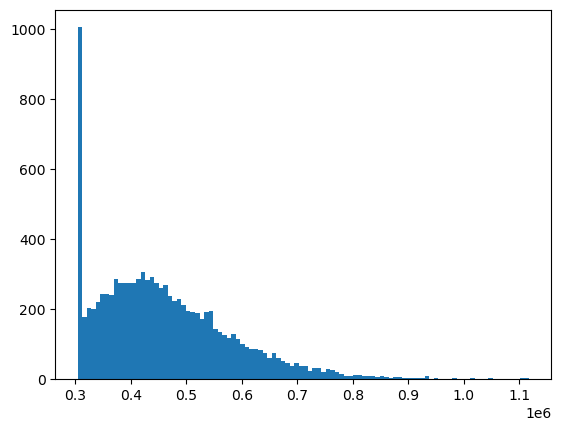

In [11]:
plt.hist(model.sim.w[:,0], bins=100)

(array([909.,  95.,  81.,  96.,  98., 112., 105., 114., 102., 143., 138.,
        132., 129., 143., 145., 176., 162., 177., 182., 155., 188., 171.,
        170., 188., 190., 215., 189., 214., 212., 188., 191., 191., 195.,
        180., 181., 171., 177., 158., 162., 142., 180., 144., 144., 166.,
        174., 124., 135., 117., 108., 111., 116., 110.,  93.,  93.,  83.,
         86.,  81.,  82.,  61.,  78.,  61.,  54.,  42.,  48.,  43.,  40.,
         28.,  38.,  36.,  30.,  30.,  30.,  16.,  11.,  15.,  15.,  12.,
         10.,  10.,  14.,   7.,   8.,   5.,   3.,   4.,   4.,   8.,   3.,
          1.,   1.,   3.,   0.,   4.,   0.,   2.,   4.,   0.,   2.,   2.,
          3.]),
 array([ 0.        ,  0.19057083,  0.38114167,  0.5717125 ,  0.76228334,
         0.95285417,  1.143425  ,  1.33399584,  1.52456667,  1.71513751,
         1.90570834,  2.09627917,  2.28685001,  2.47742084,  2.66799167,
         2.85856251,  3.04913334,  3.23970418,  3.43027501,  3.62084584,
         3.81141668,  4.00

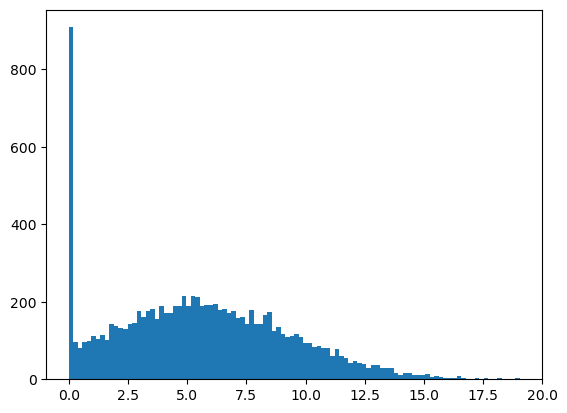

In [12]:
plt.hist(model.sim.k[:,0], bins=100)

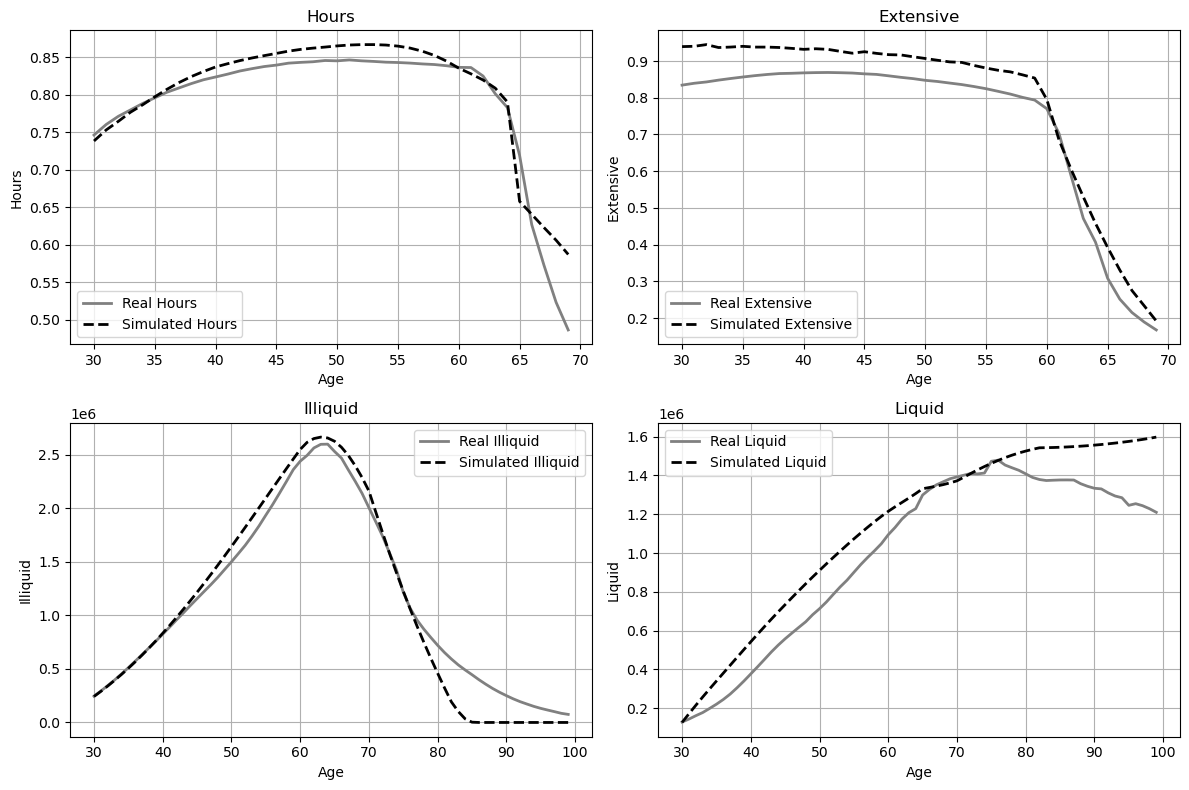

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# prepare your data dict
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# set up 2x2 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (key, (sim, emp)) in zip(axes, a_dict.items()):
    x_vals = np.arange(len(emp)) + par.start_age

    # real data: solid grey
    ax.plot(x_vals, emp,
            color='grey',
            linestyle='-',
            linewidth=2,
            label=f"Real {key.capitalize()}")

    # simulated data: darker dashed
    ax.plot(x_vals, sim,
            color='black',
            linestyle='--',
            linewidth=2,
            label=f"Simulated {key.capitalize()}")

    ax.set_xlabel("Age")
    ax.set_ylabel(key.capitalize())
    ax.set_title(key.capitalize())
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()


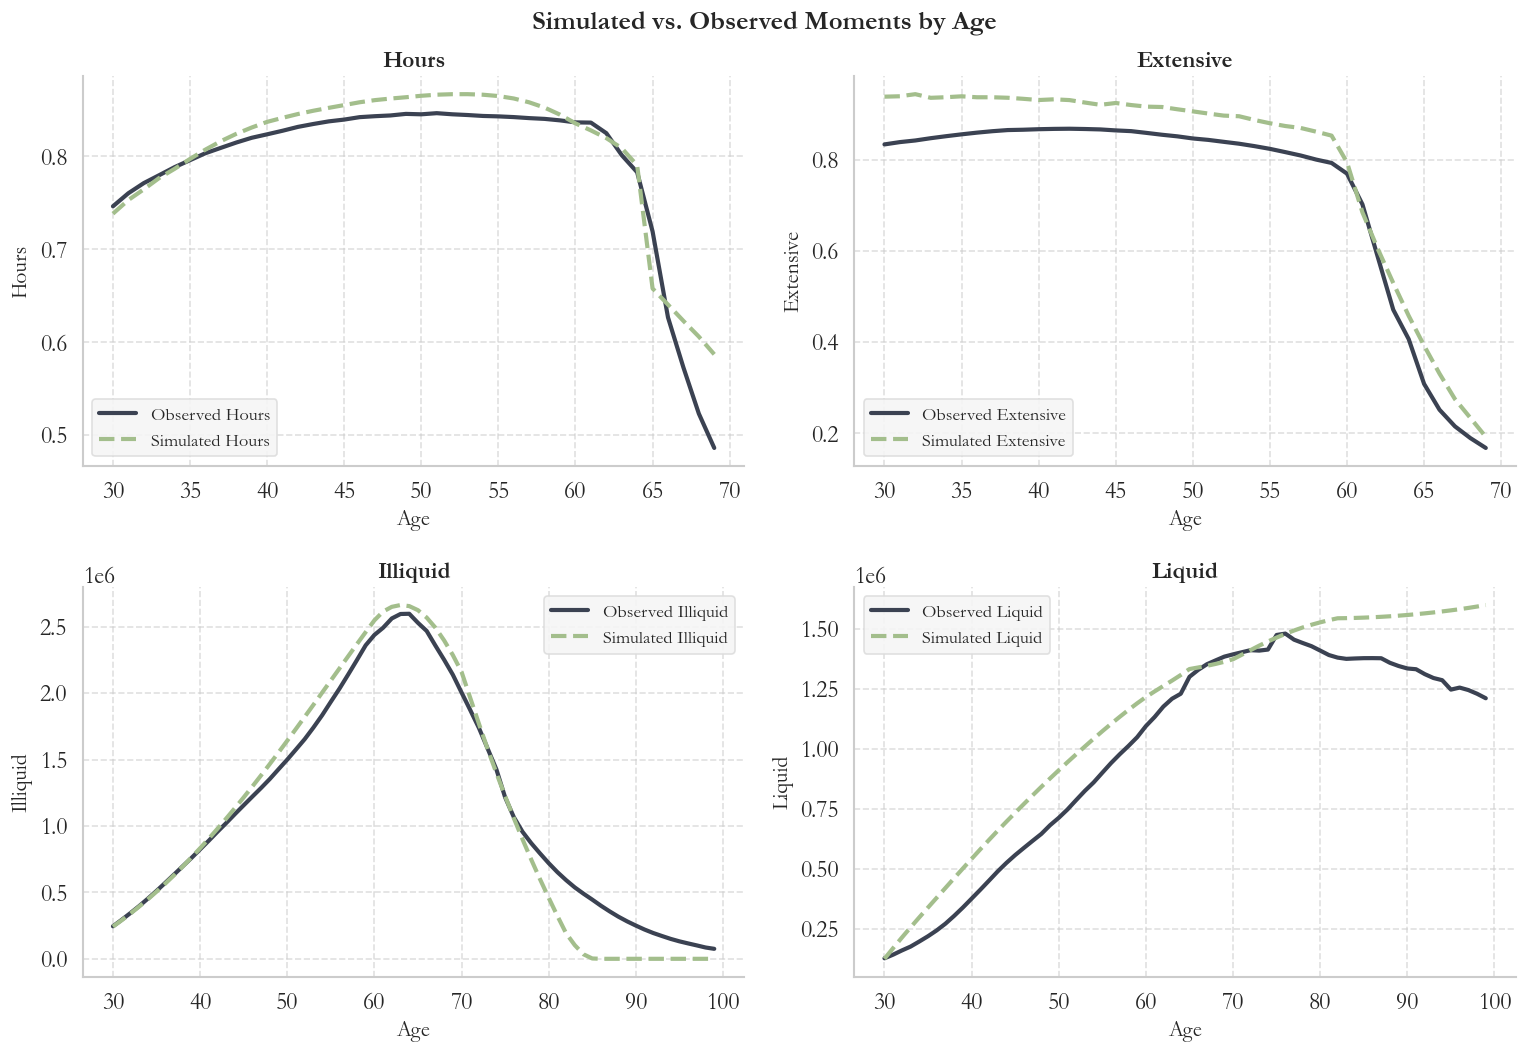

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graph_format import custom_palette, save_figure

# Apply global styling
sns.set_theme(context="notebook", style="whitegrid", font="garamond", palette=custom_palette, font_scale=1.3)

# Prepare data dict
a_dict = {
    'Hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'Extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'Illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'Liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(13, 9))
axes = axes.flatten()

for idx, (ax, (key, (sim, emp))) in enumerate(zip(axes, a_dict.items())):
    x_vals = np.arange(len(emp)) + par.start_age

    # Real data: solid custom color
    ax.plot(x_vals, emp,
            color=custom_palette[0],
            linestyle='-',
            linewidth=2.5,
            label=f"Observed {key}")

    # Simulated data: dashed custom color
    ax.plot(x_vals, sim,
            color=custom_palette[1],
            linestyle='--',
            linewidth=2.5,
            label=f"Simulated {key}")

    ax.set_xlabel("Age", fontsize=13)
    ax.set_ylabel(key, fontsize=13)
    ax.set_title(key, fontsize=14, fontweight="semibold")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(fontsize=11, frameon=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle("Simulated vs. Observed Moments by Age", fontsize=16, fontweight="bold")
fig.tight_layout()
fig.subplots_adjust(top=0.92)

# Save with consistent style
save_figure(fig, "sim_vs_real_moments_by_age.png")
plt.show()


Old best variables:

In [15]:
theta_old = ([0.982, 1.060, 3.877, 7.814, 0.02, 0.009])